In [ ]:
import numpy as np
import ctypes, time, os
import pickle

# Import visualization stuff
import matplotlib.pyplot as plt
import nibabel as nib

# Import popeye stuff
import popeye.utilities_cclab as utils
from popeye.visual_stimulus import VisualStimulus

from itertools import product

# Load helper functions
from dataloader import *
from fit_utils import *
# from fitutils_css import *
import ctypes

In [ ]:
print('Initializing parameters...')
codeStartTime = time.perf_counter()
params = {}
params['subjID'] = 'JC'
# Got these from Zhengang, and he got it from rsvp_params.txt
params['viewingDistance'] = 83.5 #63 #83.5 # in cm
params['screenWidth'] = 36.2 #35 #36.2 # in cm
params['scaleFactor'] = 1
params['resampleFactor'] = 1
params['dtype'] = ctypes.c_int16

p = set_paths(params)

# Load stimulus
bar, _ = load_stimuli(p)
bar = bar[:, :, 0:201]
# Mirror y axis (this is done because popeye flips the y axis)
bar = np.flip(bar, axis=0)

# copy_files(p, params)

# Extract number of TRs
method = 'ss5'
func_data = nib.load(p['pRF_' + method])
f_header = func_data.header
params['tr_length'] = f_header['pixdim'][4]
params['voxel_size'] = [f_header['pixdim'][i] for i in range(1, 4)]
params['nTRs'] = func_data.shape[-1]

# Load scan data
print('Loading scan data...')
simDataPath = os.path.join(p['pRF_data'], 'Simulation', 'simulatedVoxels.pkl')
with open(simDataPath, 'rb') as f:
    scan_data = pickle.load(f)

# load true fit data
trueFitPath = os.path.join(p['pRF_data'], 'Simulation', 'simulatedParams.pkl')
with open(trueFitPath, 'rb') as f:
    trueFitFile = pickle.load(f)
    trueFit_estims = np.asarray(trueFitFile['params_vox'])
    baseline_vox = trueFitFile['baseline_vox']

    # This is originally (x, y, sigma, n)
    # We need to convert it to (theta, r2, rho, sigma, n, x, y, beta, baseline)
    trueFit_data = np.empty((trueFit_estims.shape[0], 9))
    trueFit_data[:, 0] = np.mod(np.arctan2(trueFit_estims[:, 1], trueFit_estims[:, 0]), 2*np.pi)
    trueFit_data[:, 1] = 1
    trueFit_data[:, 2] = np.sqrt(trueFit_estims[:, 0]**2 + trueFit_estims[:, 1]**2)
    trueFit_data[:, 3] = trueFit_estims[:, 2]
    trueFit_data[:, 4] = trueFit_estims[:, 3]
    trueFit_data[:, 5] = trueFit_estims[:, 0]
    trueFit_data[:, 6] = trueFit_estims[:, 1]
    trueFit_data[:, 7] = np.zeros(trueFit_estims.shape[0])
    trueFit_data[:, 8] = baseline_vox

# Select first N voxels
nvox = 25
scan_data = scan_data[:nvox, :]
trueFit_data = trueFit_data[:nvox, :]
scan_data_orig = scan_data.copy()
scan_data = remove_trend(scan_data, method='all')
# Plot 5 random voxels before and after detrending
f, axs = plt.subplots(2, 5, figsize=(20, 10))
for i in range(5):
    ax = axs[0, i]
    ax.plot(scan_data_orig[i])
    ax.set_title('Original')
    ax = axs[1, i]
    ax.plot(scan_data[i])
    ax.set_title('Detrended')
plt.savefig(os.path.join(p['pRF_data'], 'Simulation/figures/detrended_voxels.png'), dpi=300)

nvoxs = scan_data.shape[0]
print(f"Running model-fit on {nvoxs} voxels")

# print(f"Running model-fit on {len(np.argwhere(brainmask_data))} voxels")
# scan_data_brainmask = scan_data.copy()
# print(scan_data_brainmask.shape)
# [xi, yi, zi] = np.nonzero(scan_data_brainmask)
# indices = [(xi[i], yi[i], zi[i]) for i in range(len(xi))]
# num_voxels = len(indices)
timeseries_data = scan_data.copy()#scan_data_brainmask[xi, yi, zi, :]
indices = [(0, 0, i) for i in range(nvoxs)]
# print(f"Running model-fit on {num_voxels} voxels")

# create stimulus object from popeye
print('Creating stimulus object...')
stimulus = VisualStimulus(bar.astype('int16'),
                        params['viewingDistance'],
                        params['screenWidth'],
                        params['scaleFactor'],
                        params['tr_length'],
                        params['dtype'],
)

In [3]:
# set search grids
Ns = 50
x_grid = np.concatenate((np.linspace(-stimulus.deg_x0.max(), stimulus.deg_x0.max(), Ns//2),
                    np.geomspace(-stimulus.deg_x0.max(), -2*stimulus.deg_x0.max(), Ns//4),
                        np.geomspace(stimulus.deg_x0.max(), 2*stimulus.deg_x0.max(), Ns//4)))
y_grid = np.concatenate((np.linspace(-stimulus.deg_y0.max(), stimulus.deg_y0.max(), Ns//2),
                        np.geomspace(-stimulus.deg_y0.max(), -2*stimulus.deg_y0.max(), Ns//4),
                        np.geomspace(stimulus.deg_y0.max(), 2*stimulus.deg_y0.max(), Ns//4)))
s_grid = np.concatenate((np.linspace(0.1, 5, 3*Ns//4), np.geomspace(5, stimulus.deg_x0.max(), Ns//4)))
n_grid = np.asarray([0.25, 0.5, 0.75, 1])
# n_grid = np.linspace(0.01, 1, Ns)
grid_space_orig = list(product(x_grid, y_grid, s_grid, n_grid))
grid_space = constraint_grids(grid_space_orig, stimulus)
print(f'Number of grid points: {len(grid_space)}')

param_width = [np.mean(np.diff(x_grid)), np.mean(np.diff(y_grid)), np.mean(np.diff(s_grid)), np.mean(np.diff(n_grid))]
# param_width = np.asarray(round(param_width, 4))

tstamp_start = time.perf_counter()

if os.path.exists(p['gridfit_path']):
    print("Loading grid predictions from disk")
    grid_preds = np.load(p['gridfit_path'])
    # Print shape 
    print(grid_preds.shape)
else:
    print("Grid predictions don't exist. Generating them")
    grid_preds = getGridPreds(grid_space, stimulus, p, timeseries_data)

tstamp_gridpred = time.perf_counter()
print_time(tstamp_start, tstamp_gridpred, 'Grid predictions')

Number of grid points: 248468
Loading grid predictions from disk
(248468, 201)
Grid predictions took 4.85 seconds


In [56]:
from tqdm import tqdm
from multiprocessing import Pool, cpu_count


def overload_estimate(estimate, data, prediction, dtype):
    # Returns (theta, r2, rho, sigma, n, x, y, beta, baseline)
    X = np.vstack((np.ones(len(prediction), dtype=dtype), prediction)).T
    XtX = np.dot(X.T, X)
    XtY = np.dot(X.T, data)
    betas = np.linalg.solve(XtX, XtY)
    scaled_prediction = np.dot(X, betas)
    r2 = np.corrcoef(data, scaled_prediction)[0, 1]**2
    r2 = r2.astype(dtype)
    theta = np.mod(np.arctan2(estimate[1], estimate[0], dtype=dtype), 2*np.pi, dtype=dtype)
    rho = np.sqrt(estimate[0]**2 + estimate[1]**2, dtype=dtype)
    return (theta, r2, rho, estimate[2], estimate[3], estimate[0], estimate[1], betas[1], betas[0])

def compute_rmse(args):
    data, predictor_series, dtype = args
    predictor_series = predictor_series.reshape(-1, 1)
    y = data
    X = np.hstack((np.ones((predictor_series.shape[0], 1), dtype=dtype), predictor_series))
    XtX = np.dot(X.T, X)
    XtX_inv = np.linalg.inv(XtX)
    XtX_inv_Xt = np.dot(XtX_inv, X.T)
    betas = np.dot(XtX_inv_Xt, y)

    predictions = np.dot(X, betas)

    rmse = np.mean((data - predictions)**2)        
    return rmse

def process_voxel(args):
    iin, timeseries_data, grid_preds, grid_space, indices, dtype = args
    ngrids = len(grid_preds)
    
    args = [(timeseries_data, grid_preds[j], dtype) for j in range(ngrids)]
    rmses = np.array([compute_rmse(arg) for arg in args])
    best_grid_idx = np.argmin(rmses)
    best_grid_estim = grid_space[best_grid_idx]
    best_grid_pred = grid_preds[best_grid_idx]
    overload_estim = overload_estimate(best_grid_estim, timeseries_data, best_grid_pred, dtype)
    iix, iiy, iiz = indices[iin]
    
    return iix, iiy, iiz, overload_estim

def get_grid_estims(grid_preds, grid_space, timeseries_data, gFit, indices):
    
    nvoxs = len(timeseries_data)
    
    # timeseries_data = utils.generate_shared_array(timeseries_data, ctypes.c_double)
    # grid_preds = utils.generate_shared_array(grid_preds, ctypes.c_double)
    timeseries_data = utils.generate_shared_array(timeseries_data, ctypes.c_float)
    grid_preds = utils.generate_shared_array(grid_preds, ctypes.c_float)
    grid_space = utils.generate_shared_array(np.asarray(grid_space, dtype=np.float32), ctypes.c_float)
    args = [(iin, timeseries_data[iin, :], grid_preds, grid_space, indices, grid_space.dtype) for iin in range(nvoxs)]
    
    with Pool(cpu_count()) as pool:
        results = []
        for result in tqdm(pool.imap(process_voxel, args), total=nvoxs, dynamic_ncols=False):
            results.append(result)
    
    for iix, iiy, iiz, overload_estim in results:
        gFit[iix, iiy, iiz, :] = overload_estim

    return gFit

In [57]:
############################  GRID FIT ################################
print('Starting grid fit...')
tstamp_gridpred = time.perf_counter()
RF_ss5_gFit = np.empty((1, 1, timeseries_data.shape[0], 9))
RF_ss5_gFit = get_grid_estims(grid_preds, grid_space, timeseries_data, RF_ss5_gFit, indices)
tstamp_gridestim = time.perf_counter()
print_time(tstamp_gridpred, tstamp_gridestim, 'Grid fit1')

Starting grid fit...


100%|██████████| 25/25 [01:42<00:00,  4.10s/it]

Grid fit1 took 2 minutes and 43 seconds


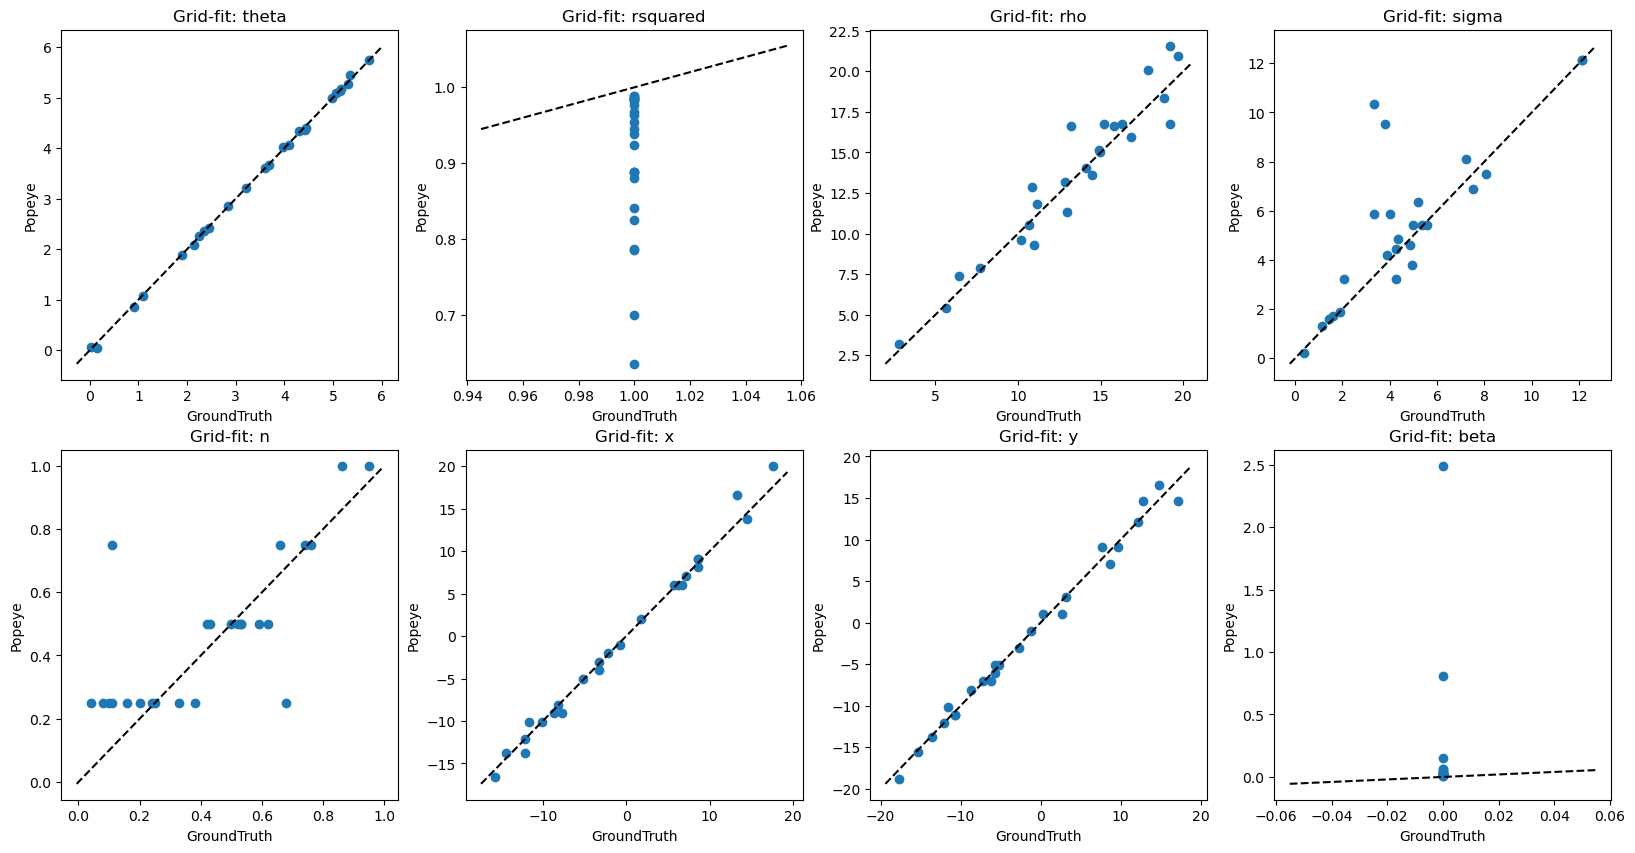

In [35]:
f0, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
for i in range(8):
    ax = axs[i]
    ax.plot(trueFit_data[:,i].flatten(), RF_ss5_gFit[:, :, :, i].flatten(), 'o')
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    ax.set_title(f"Grid-fit: {['theta', 'rsquared', 'rho', 'sigma','n', 'x', 'y', 'beta'][i]}")
    ax.set_xlabel('GroundTruth')
    ax.set_ylabel('Popeye')
plt.show()